# Deepfake Voice Detection Pipeline

This notebook demonstrates the complete machine learning pipeline for detecting deepfake voices.

## Table of Contents
1. [Data Loading and Exploration](#data-loading)
2. [Feature Analysis](#feature-analysis)
3. [Model Training](#model-training)
4. [Model Evaluation](#model-evaluation)
5. [Feature Importance](#feature-importance)
6. [Model Deployment](#model-deployment)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Exploration {#data-loading}

In [2]:
# Load the dataset
url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/DATASET-balanced-JcqFJYhgnWK5P8zrmIuuMwyj9BIpH9.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLabel distribution:")
print(df['LABEL'].value_counts())

# Display first few rows
df.head()

Dataset shape: (11778, 27)

Columns: ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'LABEL']

Label distribution:
LABEL
FAKE    5889
REAL    5889
Name: count, dtype: int64


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE


In [3]:
# Basic statistics
print("Dataset Info:")
print(f"Total samples: {len(df)}")
print(f"Features: {len(df.columns) - 1}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Data types
print("\nData types:")
print(df.dtypes.value_counts())

Dataset Info:
Total samples: 11778
Features: 26
Missing values: 0
Duplicate rows: 0

Data types:
float64    26
object      1
Name: count, dtype: int64


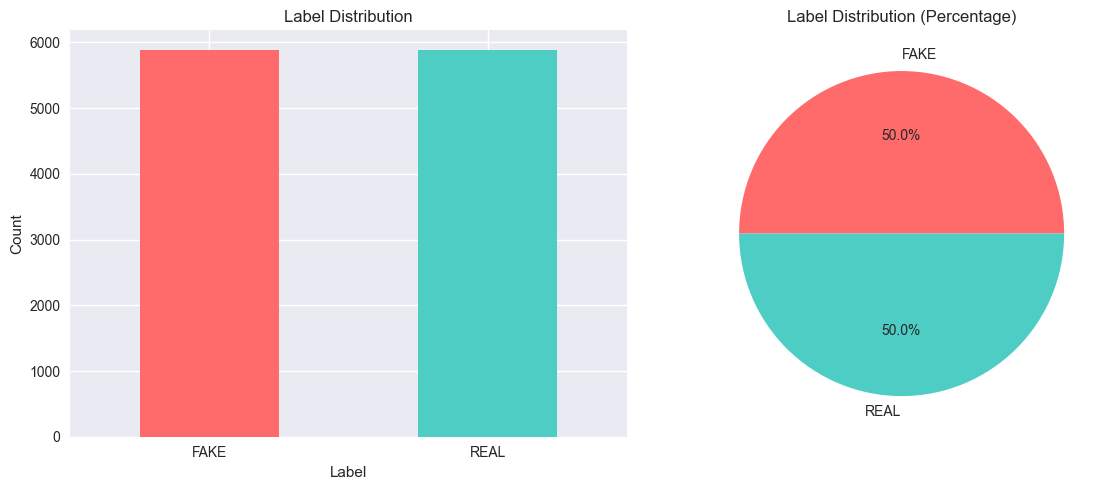

In [4]:
# Label distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
df['LABEL'].value_counts().plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Label Distribution')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
df['LABEL'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Label Distribution (Percentage)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## 2. Feature Analysis {#feature-analysis}

In [5]:
# Prepare feature columns
feature_columns = [col for col in df.columns if col != 'LABEL']
print(f"Feature columns ({len(feature_columns)}): {feature_columns}")

# Convert string columns to numeric
for col in feature_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for any remaining missing values
print(f"\nMissing values after conversion: {df[feature_columns].isnull().sum().sum()}")

Feature columns (26): ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']

Missing values after conversion: 0


In [6]:
# Statistical summary
df[feature_columns].describe()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,...,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000
mean,0.421925,0.037894,2719.201373,3050.299988,4977.617722,0.070821,-382.562312,145.056311,-24.699932,21.311292,...,-2.242488,-4.439806,-1.657739,-2.107442,-2.606924,-1.641709,-3.320340,-3.117110,-2.754034,-4.427346
std,0.069392,0.028071,1066.754739,872.258653,2170.158448,0.039292,79.593413,36.188506,27.728976,22.480432,...,7.726415,6.614913,5.121732,5.347953,4.909579,5.627377,4.597079,4.976511,4.957660,5.478806
min,0.200353,0.000043,756.163229,1096.903152,1063.964279,0.015504,-1055.002197,-83.816765,-132.491104,-47.770000,...,-29.636639,-30.168062,-19.717999,-21.553347,-28.876045,-20.307486,-22.753056,-19.623880,-23.890470,-25.099829
25%,0.372330,0.015098,2062.875836,2569.289971,3448.144178,0.045749,-432.928848,120.522711,-35.550402,3.635681,...,-6.863236,-8.233070,-5.178427,-5.642066,-5.760252,-4.868709,-6.435052,-5.862841,-5.514250,-7.463774
50%,0.417708,0.031870,2579.963841,3055.863462,4683.958018,0.060237,-365.756241,145.970162,-19.164229,22.218458,...,-2.438328,-4.186015,-1.530670,-2.320350,-2.447045,-0.862829,-3.230387,-2.957088,-2.726495,-3.839427
75%,0.467741,0.054046,3283.857559,3581.271953,6211.301553,0.085149,-321.772781,168.321331,-6.235028,37.017731,...,2.349474,-0.266044,1.794835,1.569430,0.837690,2.043472,-0.293191,0.068411,0.495779,-0.787292
max,0.707202,0.168958,17685.006690,7836.844404,21130.544670,0.812480,-193.430145,284.727997,67.475792,86.585747,...,28.890339,22.552883,19.462509,21.356049,13.319826,19.329521,18.873386,17.924467,11.985058,11.764109


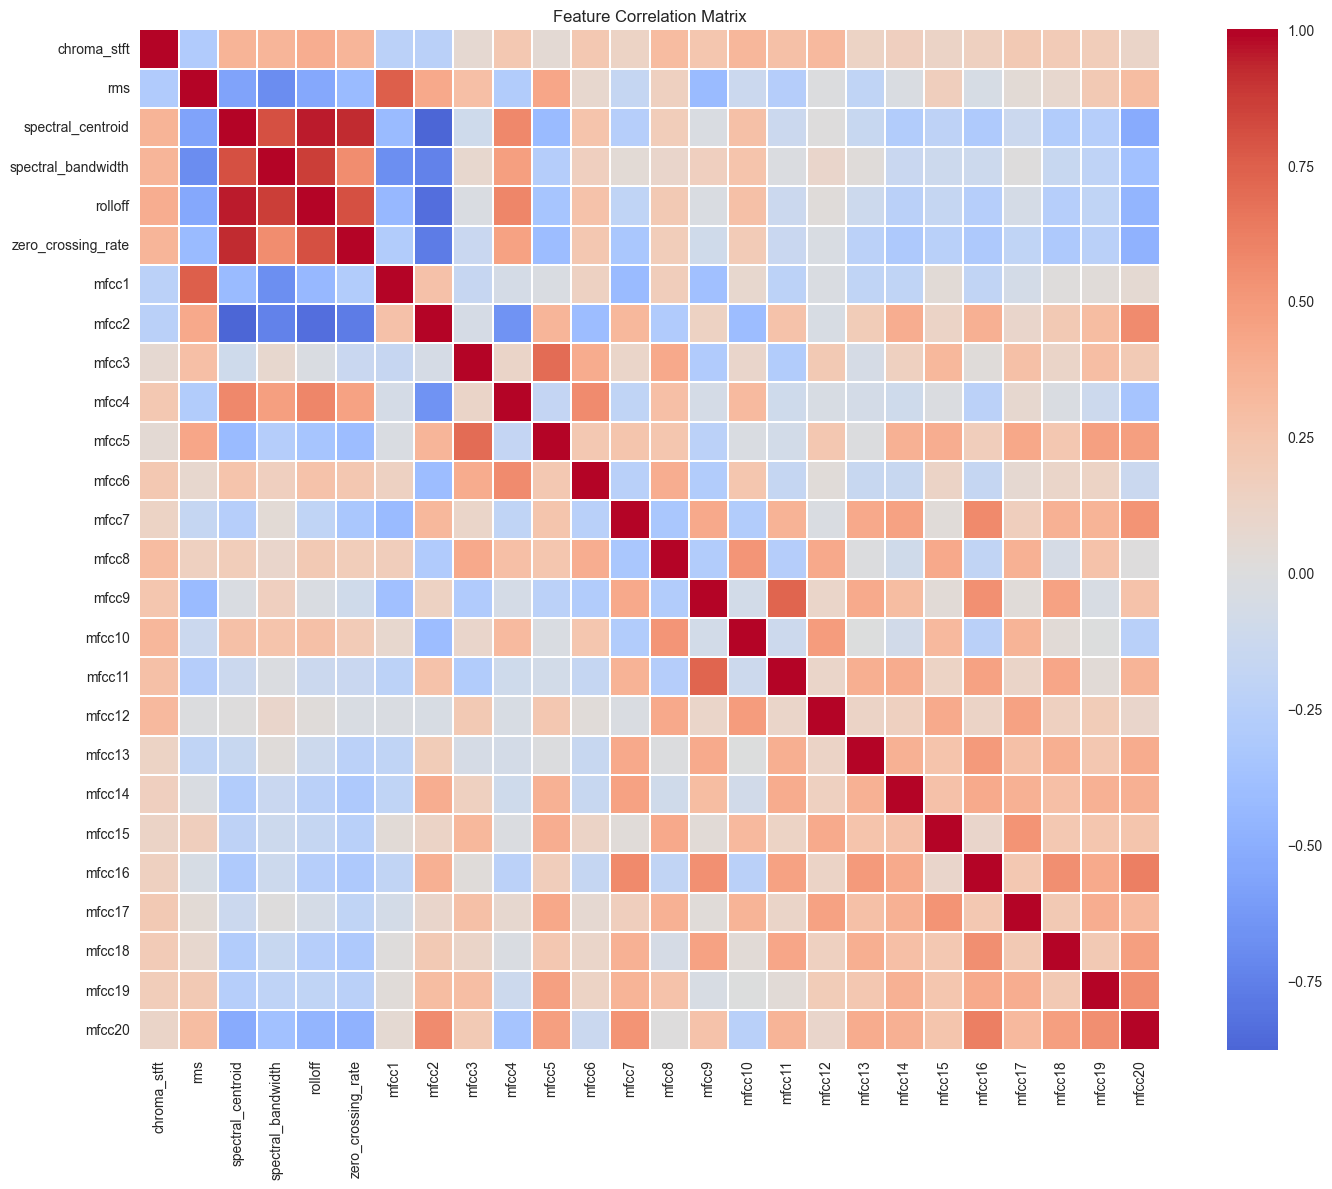

In [7]:
# Correlation matrix
plt.figure(figsize=(15, 12))
correlation_matrix = df[feature_columns].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

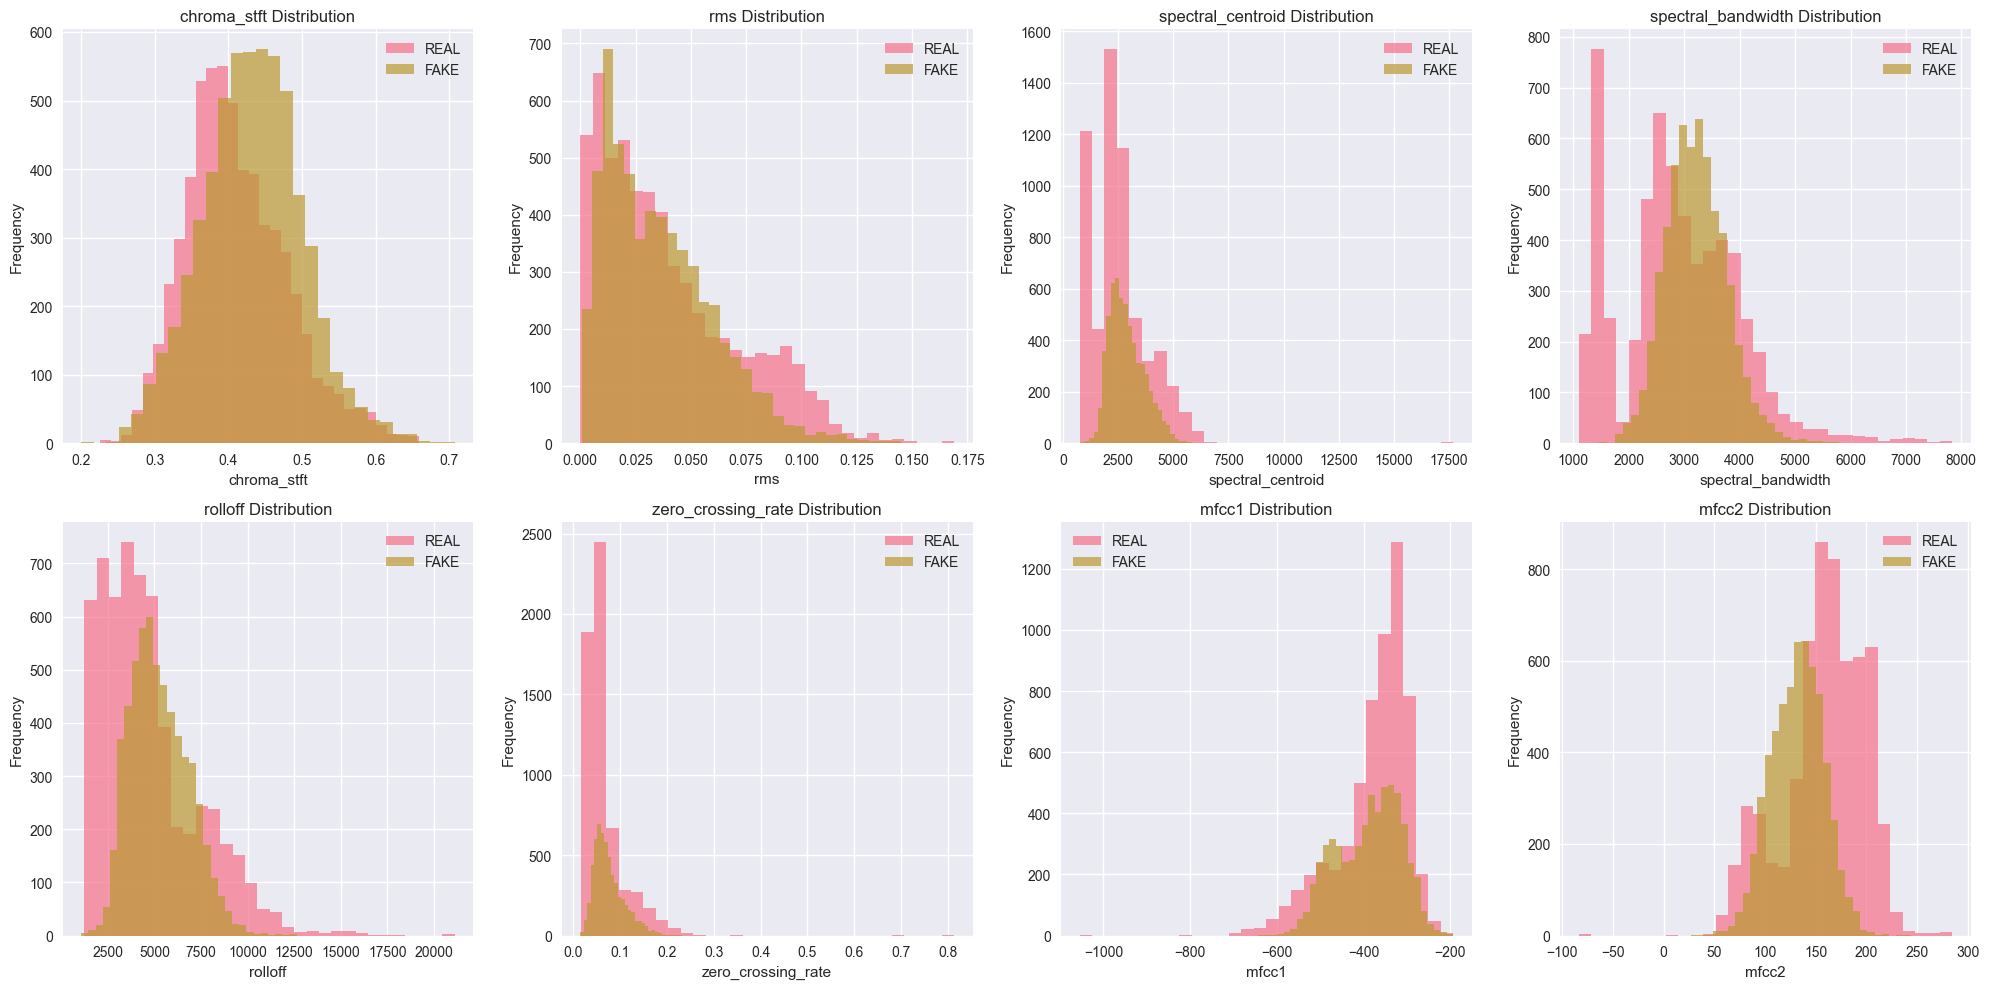

In [8]:
# Feature distributions by label
# Select a few key features for visualization
key_features = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 
                'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    for label in ['REAL', 'FAKE']:
        data = df[df['LABEL'] == label][feature]
        axes[i].hist(data, alpha=0.7, label=label, bins=30)
    
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

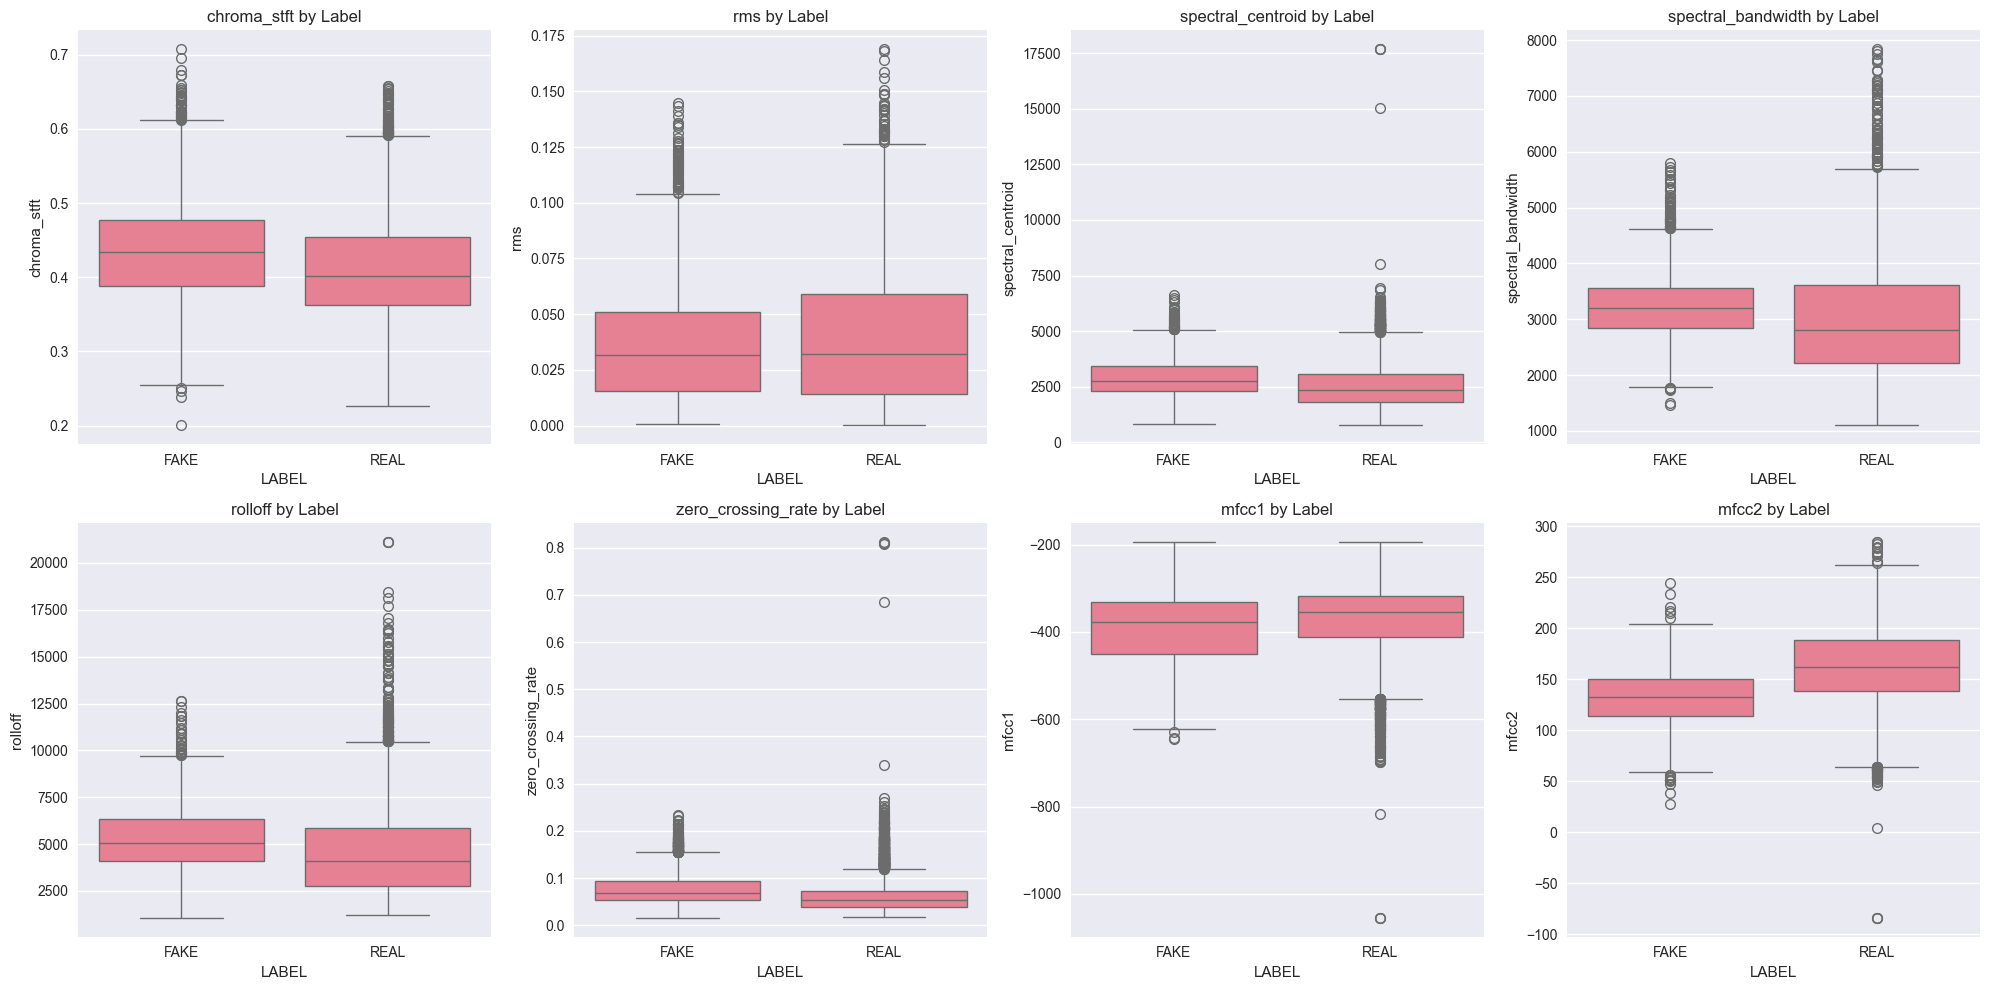

In [9]:
# Box plots for key features
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    sns.boxplot(data=df, x='LABEL', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Label')

plt.tight_layout()
plt.show()

## 3. Model Training {#model-training}

In [10]:
# Prepare data for modeling
X = df[feature_columns].values
y = df['LABEL'].values

# Handle any remaining NaN values
X = np.nan_to_num(X, nan=0.0)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Label distribution: {np.bincount(y_encoded)}")
print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

Feature matrix shape: (11778, 26)
Label distribution: [5889 5889]
Label mapping: {'FAKE': 0, 'REAL': 1}


In [11]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training label distribution: {np.bincount(y_train)}")
print(f"Test label distribution: {np.bincount(y_test)}")

Training set shape: (9422, 26)
Test set shape: (2356, 26)
Training label distribution: [4711 4711]
Test label distribution: [1178 1178]


In [12]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")


Training Random Forest...
CV F1 Score: 0.9836 (+/- 0.0041)
Test Accuracy: 0.9907
Test F1 Score: 0.9907

Training Logistic Regression...
CV F1 Score: 0.9023 (+/- 0.0158)
Test Accuracy: 0.9015
Test F1 Score: 0.9022

Training SVM...
CV F1 Score: 0.9947 (+/- 0.0036)
Test Accuracy: 0.9962
Test F1 Score: 0.9962


## 4. Model Evaluation {#model-evaluation}

In [13]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'CV F1 Mean': [results['cv_mean'] for results in model_results.values()],
    'CV F1 Std': [results['cv_std'] for results in model_results.values()],
    'Test Accuracy': [results['accuracy'] for results in model_results.values()],
    'Test Precision': [results['precision'] for results in model_results.values()],
    'Test Recall': [results['recall'] for results in model_results.values()],
    'Test F1': [results['f1'] for results in model_results.values()]
})

print("Model Comparison:")
print(comparison_df.round(4))

Model Comparison:
                 Model  CV F1 Mean  CV F1 Std  Test Accuracy  Test Precision  \
0        Random Forest      0.9836     0.0020         0.9907          0.9915   
1  Logistic Regression      0.9023     0.0079         0.9015          0.8961   
2                  SVM      0.9947     0.0018         0.9962          0.9932   

   Test Recall  Test F1  
0       0.9898   0.9907  
1       0.9083   0.9022  
2       0.9992   0.9962  


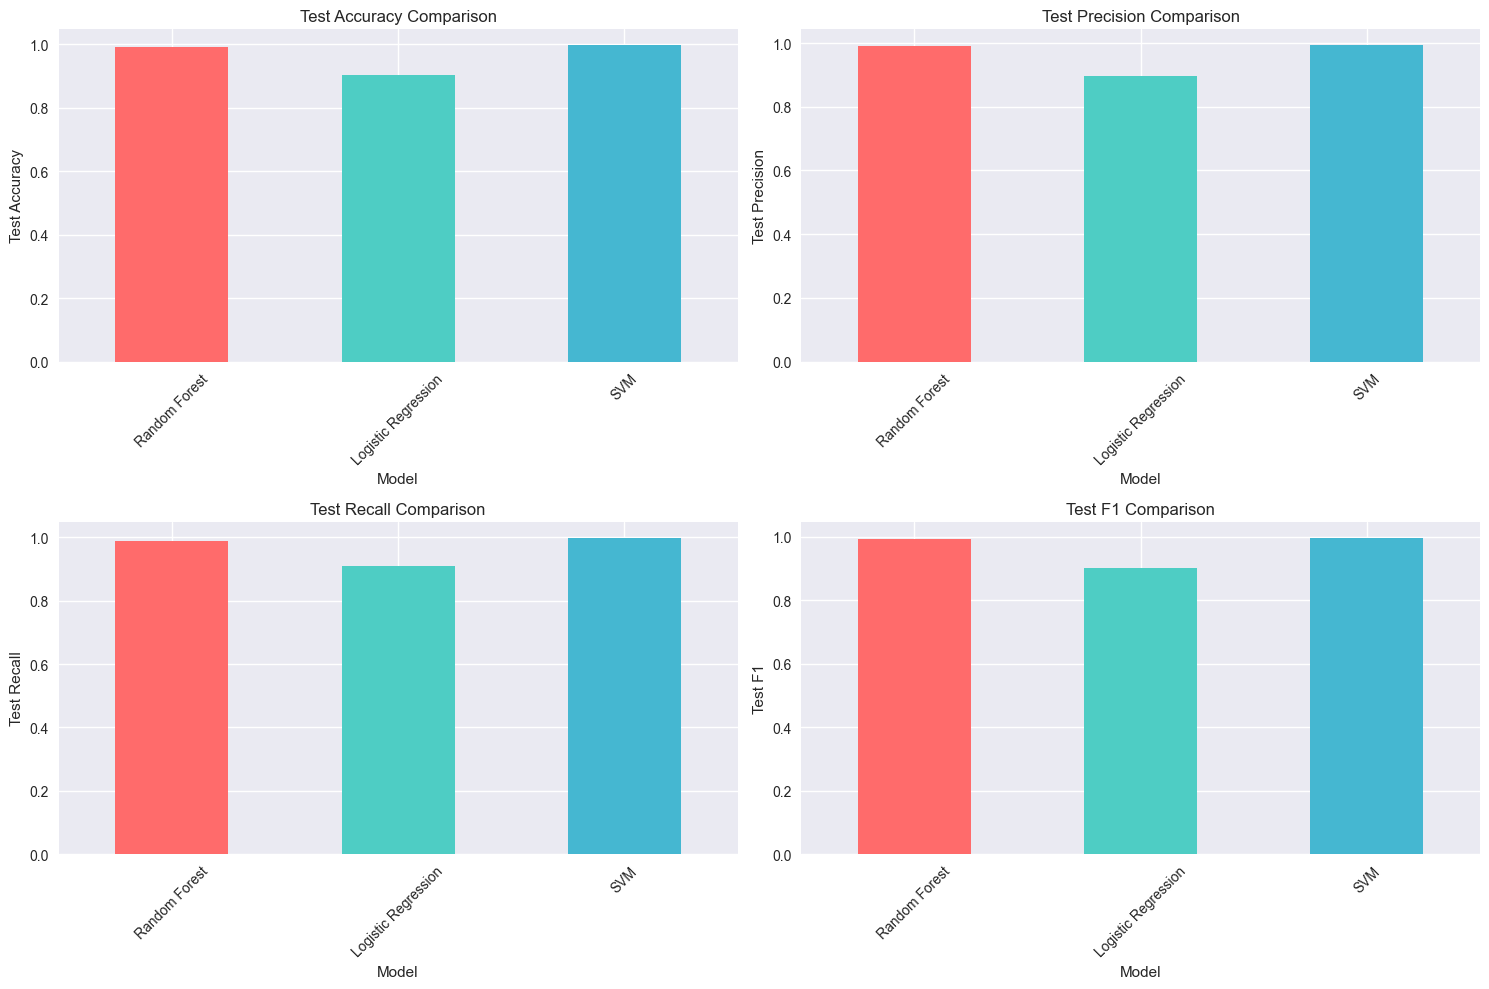

In [14]:
# Visualize model comparison
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=axes[i], 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend().remove()

plt.tight_layout()
plt.show()

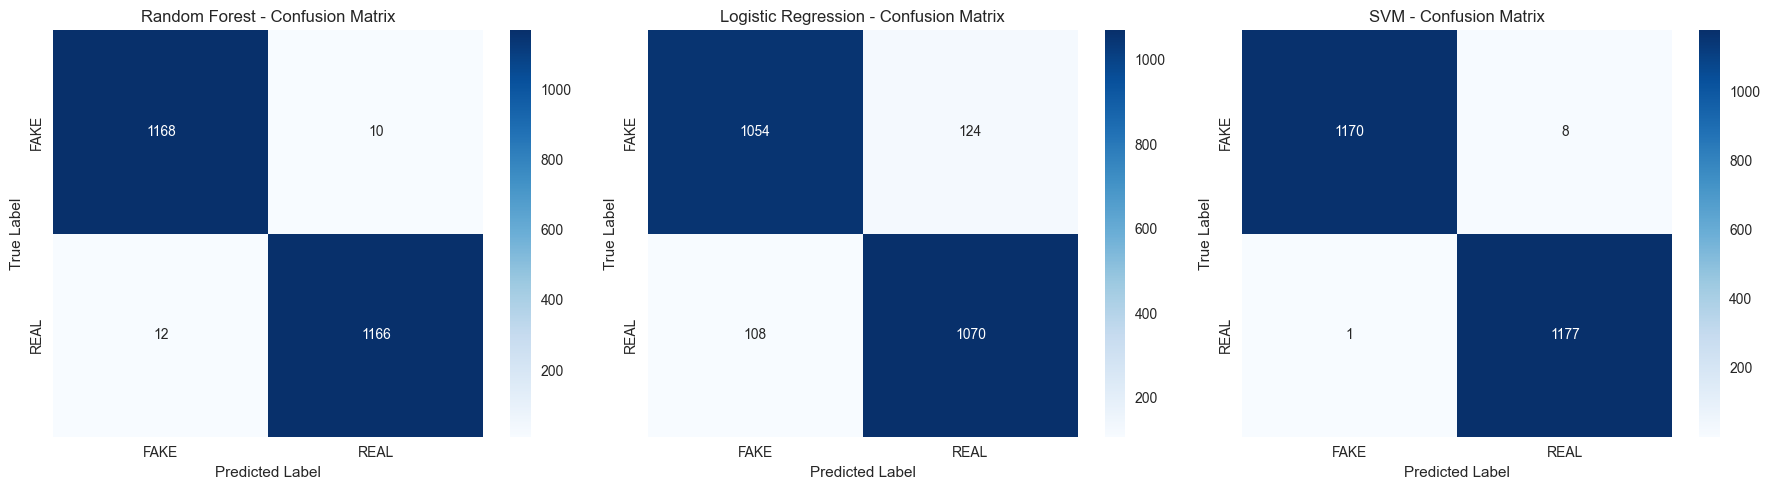

In [15]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, results) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'], ax=axes[i])
    axes[i].set_title(f'{name} - Confusion Matrix')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

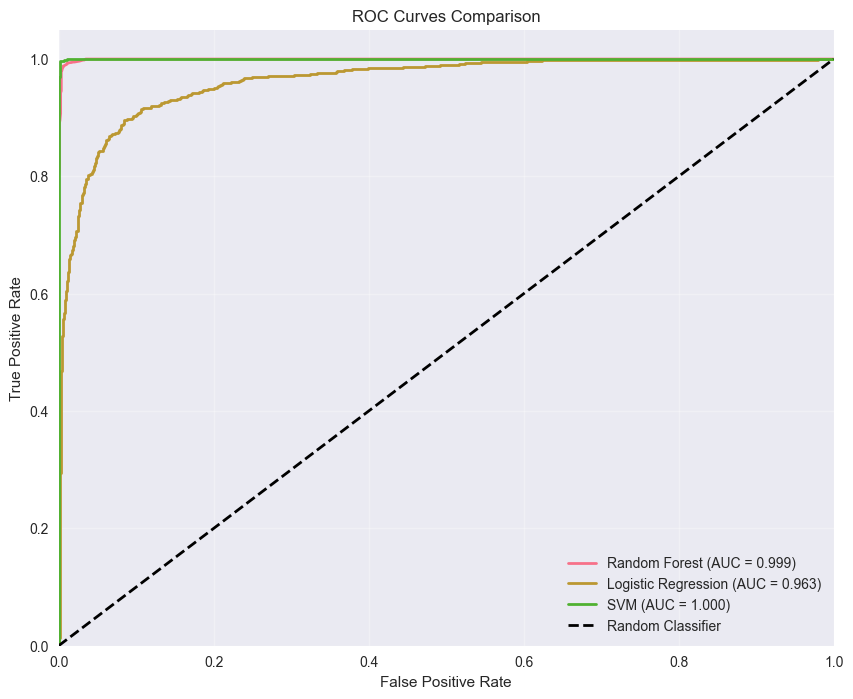

In [16]:
# ROC curves
plt.figure(figsize=(10, 8))

for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'][:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2, 
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## 5. Feature Importance {#feature-importance}

In [17]:
# Feature importance for Random Forest (best performing model)
best_model_name = comparison_df.loc[comparison_df['Test F1'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']

print(f"Best performing model: {best_model_name}")

if hasattr(best_model, 'feature_importances_'):
    # Get feature importance
    importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))
else:
    print(f"{best_model_name} does not support feature importance.")

Best performing model: SVM
SVM does not support feature importance.


In [18]:
# Feature importance heatmap (for MFCC features)
if hasattr(best_model, 'feature_importances_'):
    mfcc_features = [col for col in feature_columns if col.startswith('mfcc')]
    mfcc_importance = []
    
    for feature in mfcc_features:
        idx = feature_columns.index(feature)
        mfcc_importance.append(importance[idx])
    
    # Reshape for heatmap (4x5 grid for 20 MFCC features)
    mfcc_matrix = np.array(mfcc_importance).reshape(4, 5)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(mfcc_matrix, annot=True, fmt='.4f', cmap='YlOrRd',
                xticklabels=[f'MFCC{i+1}' for i in range(5)],
                yticklabels=[f'Group {i+1}' for i in range(4)])
    plt.title('MFCC Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

## 6. Model Deployment {#model-deployment}

In [19]:
# Save the best model and preprocessing components
import joblib
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save model
model_data = {
    'model': best_model,
    'model_type': best_model_name.lower().replace(' ', '_'),
    'training_history': {
        'cv_scores': model_results[best_model_name]['cv_scores'],
        'cv_mean': model_results[best_model_name]['cv_mean'],
        'cv_std': model_results[best_model_name]['cv_std'],
        'val_metrics': {
            'accuracy': model_results[best_model_name]['accuracy'],
            'precision': model_results[best_model_name]['precision'],
            'recall': model_results[best_model_name]['recall'],
            'f1': model_results[best_model_name]['f1']
        }
    }
}

joblib.dump(model_data, '../models/best_model.pkl')
print("Model saved to ../models/best_model.pkl")

# Save preprocessor
preprocessor_data = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_columns': feature_columns
}

joblib.dump(preprocessor_data, '../models/preprocessor.pkl')
print("Preprocessor saved to ../models/preprocessor.pkl")

# Save processed dataset
os.makedirs('../data', exist_ok=True)
df.to_csv('../data/DATASET-balanced.csv', index=False)
print("Dataset saved to ../data/DATASET-balanced.csv")

Model saved to ../models/best_model.pkl
Preprocessor saved to ../models/preprocessor.pkl
Dataset saved to ../data/DATASET-balanced.csv


In [20]:
# Model summary
print("=" * 50)
print("MODEL TRAINING SUMMARY")
print("=" * 50)
print(f"Best Model: {best_model_name}")
print(f"Dataset Size: {len(df)} samples")
print(f"Features: {len(feature_columns)}")
print(f"Classes: {label_encoder.classes_}")
print("\nPerformance Metrics:")
print(f"  Cross-Validation F1: {model_results[best_model_name]['cv_mean']:.4f} ± {model_results[best_model_name]['cv_std']:.4f}")
print(f"  Test Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
print(f"  Test Precision: {model_results[best_model_name]['precision']:.4f}")
print(f"  Test Recall: {model_results[best_model_name]['recall']:.4f}")
print(f"  Test F1 Score: {model_results[best_model_name]['f1']:.4f}")
print("\nFiles Saved:")
print("  - ../models/best_model.pkl")
print("  - ../models/preprocessor.pkl")
print("  - ../data/DATASET-balanced.csv")
print("=" * 50)

MODEL TRAINING SUMMARY
Best Model: SVM
Dataset Size: 11778 samples
Features: 26
Classes: ['FAKE' 'REAL']

Performance Metrics:
  Cross-Validation F1: 0.9947 ± 0.0018
  Test Accuracy: 0.9962
  Test Precision: 0.9932
  Test Recall: 0.9992
  Test F1 Score: 0.9962

Files Saved:
  - ../models/best_model.pkl
  - ../models/preprocessor.pkl
  - ../data/DATASET-balanced.csv
